In [1]:
import csv
import itertools

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import itertools
import pickle

from matplotlib import rcParams
from scipy.optimize import curve_fit, root_scalar
from scipy.signal import savgol_filter

In [2]:
rcParams['figure.figsize'] = 12, 5
plt.rcParams.update({'font.size': 15})
plotsize = (10, 6)
legend_size = 12
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

# 1. Import and Plot Spectroscopy Data

### 1.1 Define Functions

In [3]:
def get_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    voltage_vector = data1['voltage_vector']

    voltage_vector = np.asarray(voltage_vector[0])
    specFreqVector1 = np.asarray(specFreqVector1[0])*1e-9

    
    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return voltage_vector, specFreqVector1, Z

In [4]:
def plot_spec_data(voltage_data, frequency_data, transmission_data, qubit_name=None, title=None, fit_voltages=None, fit_frequencies=None, vmin=-2, vmax=10):
    

    # Initialize the plot
    plt.figure()

    voltage_min = voltage_data[0]
    voltage_max = voltage_data[-1]
    voltage_step = voltage_data[1] - voltage_data[0]

    frequency_min = frequency_data[0]
    frequency_max = frequency_data[-1]
    frequency_step = frequency_data[1] - frequency_data[0]

    extent = (voltage_min - voltage_step / 2, 
              voltage_max + voltage_step / 2, 
              frequency_min - frequency_step / 2, 
              frequency_max + frequency_step / 2)

    plt.imshow(transmission_data, interpolation='none', vmin=vmin, vmax=vmax, origin='lower', cmap='summer', aspect='auto', extent=extent, alpha=0.7)


    if fit_frequencies is not None and fit_voltages is not None:
        plt.plot(fit_voltages, fit_frequencies, marker='o',linestyle='', color='red', ms=2)
        
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar(label='Transmission (a.u.)')
    
    if title is None:
        title = 'Qubit Transmission sweep'
        if qubit_name is not None:
            title = f'{qubit_name} Transmission sweep'
    
    plt.title(title)
    plt.show()


In [18]:
def get_avoided_crossing_frequencies(voltages, frequencies, transmission_data, voltage_start_index=0, middle_frequency_index=None, start_index=5, frequency_index_span=100, plot_fits=False):
    '''
    :param frequency_index_span: number of points around peak to try fit
    '''
    
    center_frequencies_left = []
    center_frequency_errors_left = []
    voltages_with_fit_left = []
    
    center_frequencies_right = []
    center_frequency_errors_right = []
    voltages_with_fit_right = []
    
    if middle_frequency_index is None:
        middle_frequency_index = transmission_data.shape[0]//2
        
    
    if isinstance(start_index, int):
        start_indices = [start_index] * transmission_data.shape[1]
    else:
        start_indices = list(start_index)
    
    for i in range(voltage_start_index, transmission_data.shape[1]):
        # do the following twice, one for each half of the avoided crossing
        for j in range(2):
        
            # find peak
            if i >= len(start_indices):
                start_index = start_indices[-1]
            else:
                start_index = start_indices[i]
                
            if j == 0:
                # left half
                transmission_row = transmission_data[start_index:middle_frequency_index,i]
                frequency_row = frequencies[start_index:middle_frequency_index]

            else:
                transmission_row = transmission_data[middle_frequency_index:,i]
                frequency_row = frequencies[middle_frequency_index:]
            
            peak_index = np.argmax(transmission_row)
            peak_index = min(peak_index, len(frequencies) - 1)
            center_frequency_guess = frequency_row[peak_index]
            
            restricted_frequencies = frequency_row[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequency_row))]
            restricted_row = transmission_row[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(transmission_row))]

            
            # fit to lorentzian
            # restrict fit in range span around peak


            # apply savgol filter

            savgol_window = max(7, len(restricted_row)//2)
            filtered_row = savgol_filter(restricted_row, savgol_window, 1)

            bounds = ([restricted_frequencies[0], 0, 0, -np.inf], [restricted_frequencies[-1], np.inf, np.inf, np.inf])
            initial_guess = [center_frequency_guess, 0.001, 0.0001, 0]
            try:
                popt, pcov = curve_fit(lorentzian_fit, restricted_frequencies, filtered_row, p0=initial_guess, bounds=bounds)
            except:
                # if it fails, plot the data it was trying to fit
                plt.plot(restricted_frequencies, filtered_row, linestyle='', marker='o', label='data')
                plt.plot(restricted_frequencies, lorentzian_fit(restricted_frequencies, *initial_guess), label='guess')
                plt.xlabel('Frequency (MHz)')
                plt.title(f'Lorentzian fit for index {i}')
                plt.axvline(center_frequency_guess, color='red', linestyle=':')
                plt.legend()
                plt.show()

                print('Couldn\'t get a fit')

                # use max as the center frequency
                if j == 0:
                    center_frequencies_left.append(restricted_frequencies[np.argmax(filtered_row)])
                    voltages_with_fit_left.append(voltages[i])
                    center_frequency_errors_left.append(frequencies[-1] - frequencies[0])
                else:
                    center_frequencies_right.append(restricted_frequencies[np.argmax(filtered_row)])
                    voltages_with_fit_right.append(voltages[i])
                    center_frequency_errors_right.append(frequencies[-1] - frequencies[0])


            else:
                perr = np.sqrt(np.diag(pcov))

                if j == 0:
                    center_frequencies_left.append(popt[0])
                    center_frequency_errors_left.append(perr[0])
                    voltages_with_fit_left.append(voltages[i])
                else:
                    center_frequencies_right.append(popt[0])
                    center_frequency_errors_right.append(perr[0])
                    voltages_with_fit_right.append(voltages[i])

            if plot_fits:
                plt.plot(frequencies, transmission_data[:,i], linestyle='', marker='o', color='blue', label='data')

                fit_frequencies = np.linspace(frequencies[start_index], frequencies[-1], 1000)
                plt.plot(fit_frequencies, lorentzian_fit(fit_frequencies, *popt), color='green', label='fit')
                plt.axvline(center_frequency_guess, color='red', linestyle=':')
                
        if plot_fits:
            plt.axvline(frequencies[middle_frequency_index], color='purple', linestyle=':', label='middle cutoff frequency')
            plt.legend()

            plt.xlabel('Frequency (MHz)')
            plt.title(f'Lorentzian fit for index {i}')
            plt.show()

            print(f'Center frequency is {popt[0]} MHz')
            
    return [voltages_with_fit_left, voltages_with_fit_right], [center_frequencies_left, center_frequencies_right], [center_frequency_errors_left, center_frequency_errors_right]


In [19]:
def generate_filename(datecode, timecode, file_name_start=None):
    if file_name_start is None:
        file_name_start = '2Tone5Qubit_Tri'
    return r'V:\QSimMeasurements\Measurements\5QV1_Triangle_Lattice\pnax{}24\{}_2024{}_{}'.format(datecode, file_name_start, datecode, timecode)

In [20]:
def lorentzian_fit(x, x0, a, b, c):
    return a/(b+np.power((x-x0), 2))+c

### 1.2 Plot Data

In [21]:
qubits = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

legacy_file_start = '2Tone4Qubit_NR'

qubit_pair_to_filenames = {}
    
qubit_pair_to_filenames[('Q1', 'Q2', 4.5)] = generate_filename('0920', '1207', file_name_start=legacy_file_start)

qubit_pair_to_filenames[('Q2', 'Q3', 4.5)] = generate_filename('0920', '1647', file_name_start=legacy_file_start)


qubit_pair_to_filenames[('Q1', 'Q3', 4.5)] = {'-0.5': generate_filename('0922', '2336', file_name_start=legacy_file_start),
                                         '-0.4': generate_filename('0920', '1402', file_name_start=legacy_file_start),
                                         '-0.3': generate_filename('0920', '1426', file_name_start=legacy_file_start),
                                         '-0.2': generate_filename('0920', '1449', file_name_start=legacy_file_start),
                                         '-0.1': generate_filename('0920', '1522', file_name_start=legacy_file_start),
                                         '0.0': generate_filename('0921', '1203', file_name_start=legacy_file_start)}


qubit_pair_to_filenames[('Q1', 'Q3', 4.5)] = {'-0.5': generate_filename('0922', '2336', file_name_start=legacy_file_start),
                                         '-0.4': generate_filename('0920', '1402', file_name_start=legacy_file_start),
                                         '-0.3': generate_filename('0920', '1426', file_name_start=legacy_file_start),
                                         '-0.2': generate_filename('0920', '1449', file_name_start=legacy_file_start),
                                         '-0.1': generate_filename('0920', '1522', file_name_start=legacy_file_start),
                                          '0.0': generate_filename('0921', '1203', file_name_start=legacy_file_start),
                                          '0.08': generate_filename('1004', '1233'),
                                          '0.18': generate_filename('1004', '1358'),
                                          '0.28': generate_filename('1004', '1450'),
                                          '0.38': generate_filename('1004', '1536'),
                                          '0.48': generate_filename('1007', '1026'),}

qubit_pair_to_filenames[('Q1', 'Q3', 4.0)] = {
                                         '-0.2': generate_filename('1008', '1020'),
                                         '-0.1': generate_filename('1008', '1217'),
                                          '0.0': generate_filename('1008', '1423'),
                                          '0.1': generate_filename('1008', '1509'), #contrast not great, may redo this one
                                          '0.38': generate_filename('1009', '1324'),
                                          '0.48': generate_filename('1009', '1528')}

qubit_pair_to_filenames[('Q1', 'Q3', 5.0)] = {
                                         '-0.7': generate_filename('1010', '2018'),
                                         '-0.377': generate_filename('1010', '1916'),
                                         '-0.178': generate_filename('1010', '1804'),
                                          '0.182': generate_filename('1009', '2250'),
                                          '0.255': generate_filename('1009', '2113'),
                                          '0.325': generate_filename('1009', '1919'),
                                          '0.38': generate_filename('1009', '1753')}


In [22]:
all_qubits = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
all_couplers = ['C1', 'C2', 'C3']

all_qubit_frequencies = [4.5, 4.0, 5.0]

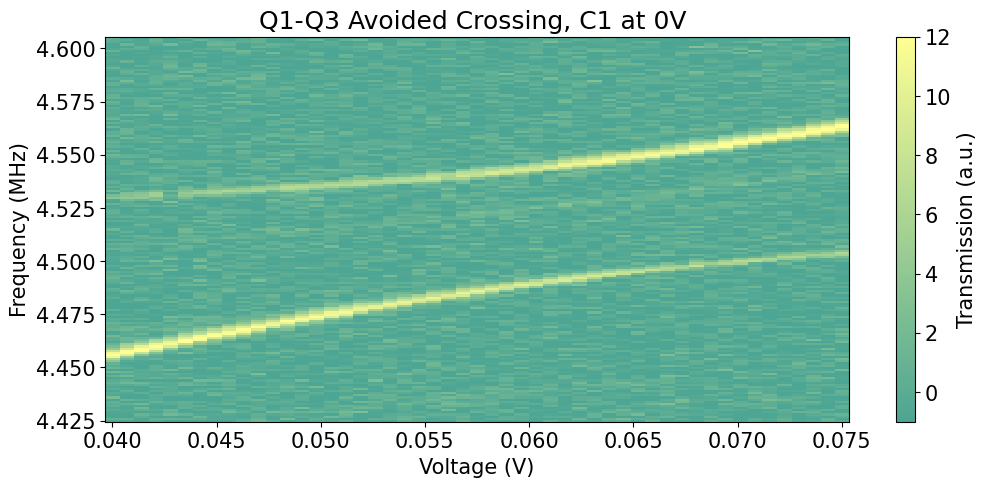

In [23]:
voltages, frequencies, transmission_data = get_data(generate_filename('0920', '1207', file_name_start=legacy_file_start))
voltages, frequencies, transmission_data = get_data(generate_filename('0921', '1203', file_name_start=legacy_file_start))
# voltages, frequencies, transmission_data = get_data(generate_filename('0920', '1647', file_name_start=legacy_file_start))


frequency_step = frequencies[1] - frequencies[0]
voltage_step = voltages[1] - voltages[0]

plot_spec_data(voltages, frequencies, transmission_data, title='Q1-Q3 Avoided Crossing, C1 at 0V ', vmax=12, vmin=-1)

# plot_spec_data(voltages, frequencies, transmission_data, title='Q1-Q2 Avoided Crossing', vmax=8, vmin=-1)
# plot_spec_data(voltages, frequencies, transmission_data, title='Q2-Q3 Avoided Crossing', vmax=5, vmin=-1)


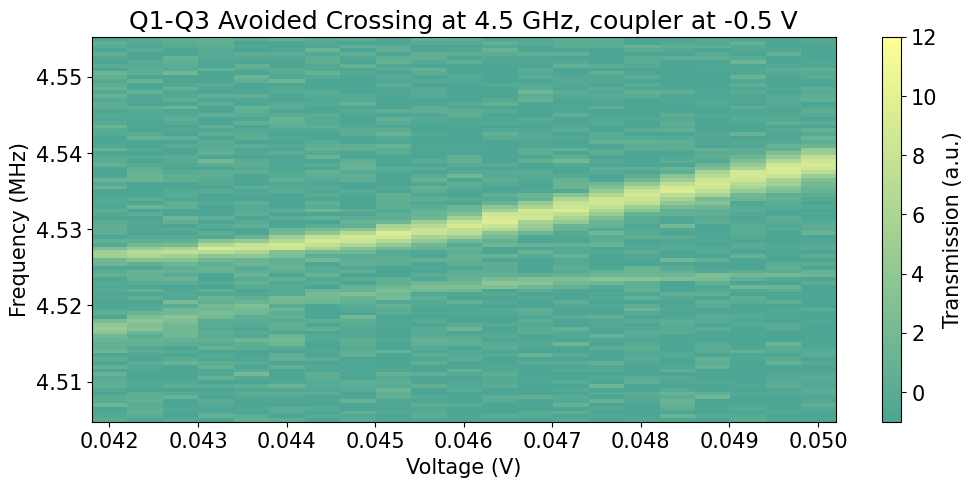

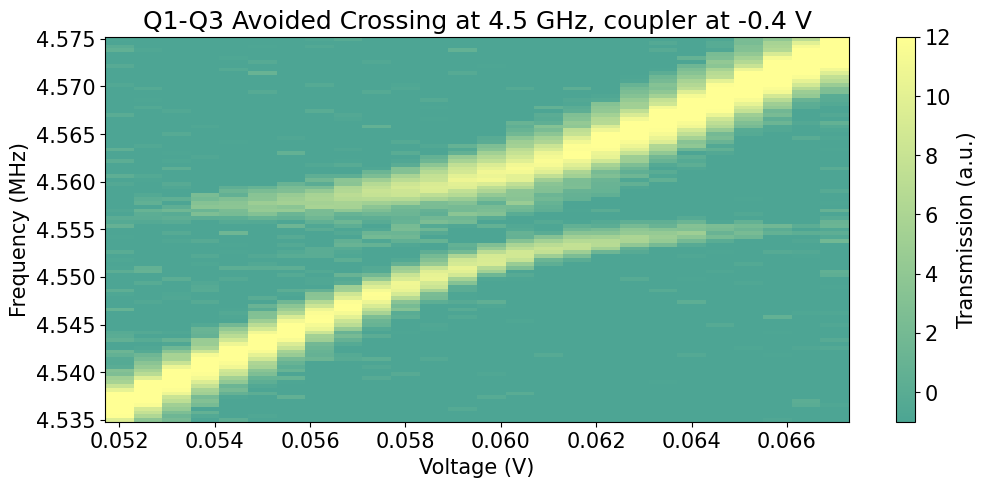

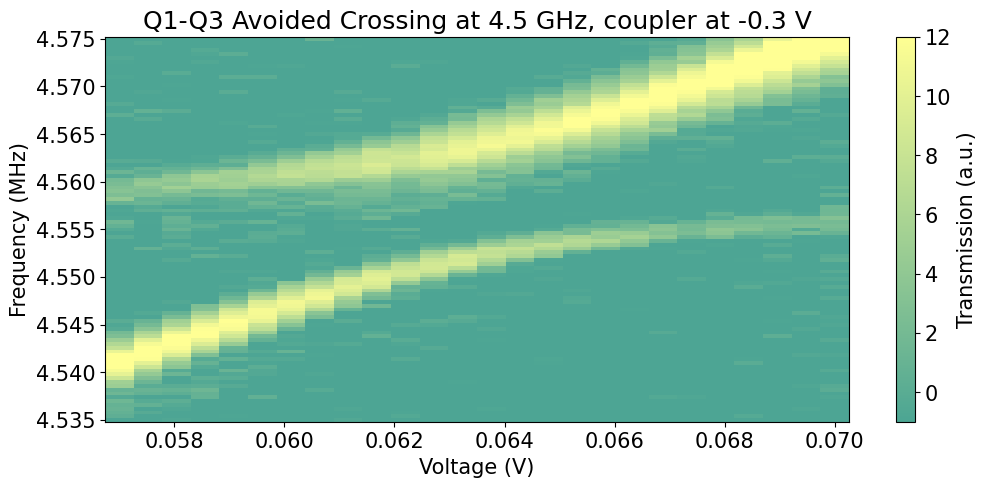

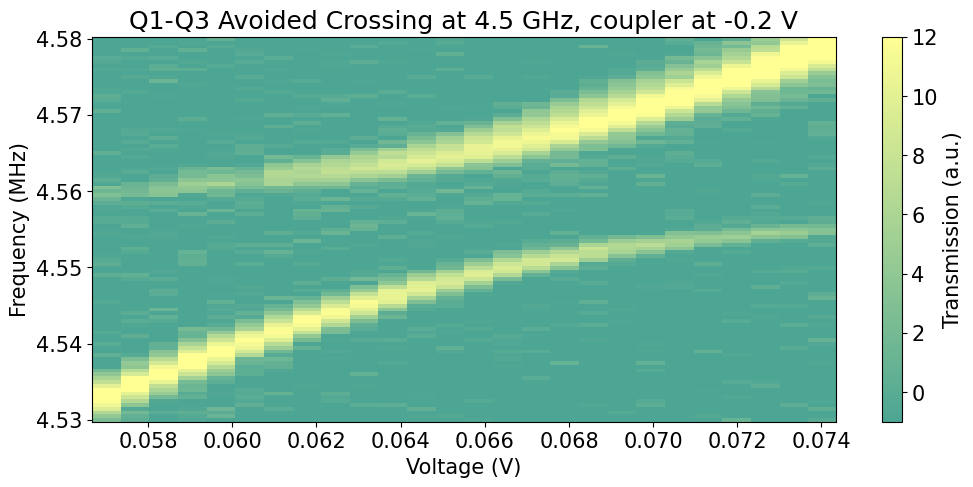

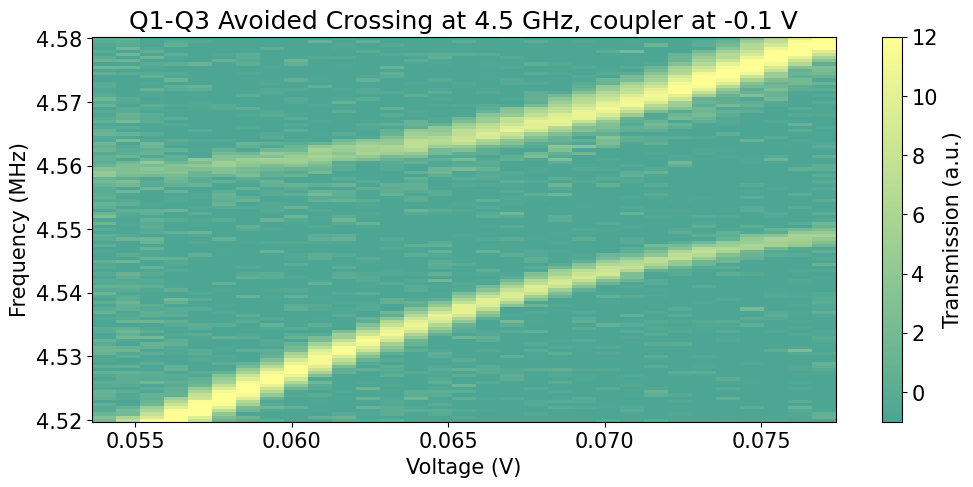

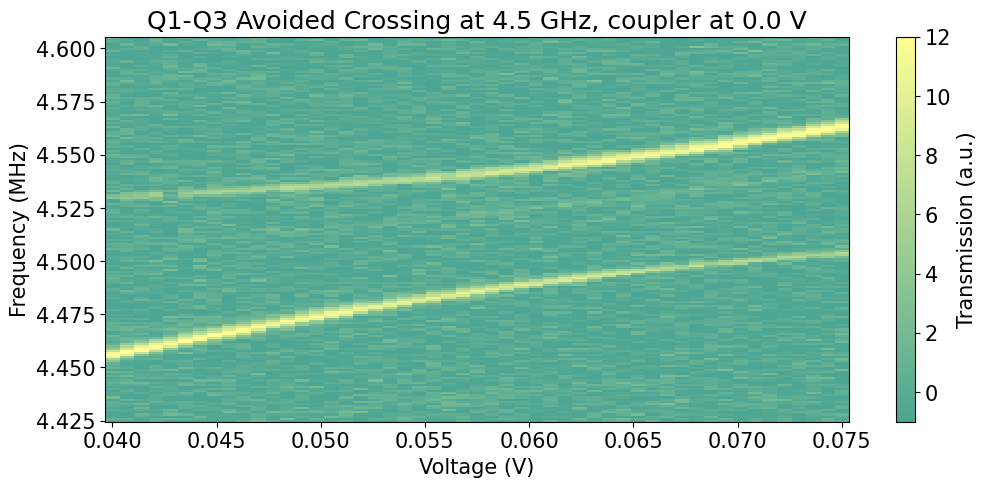

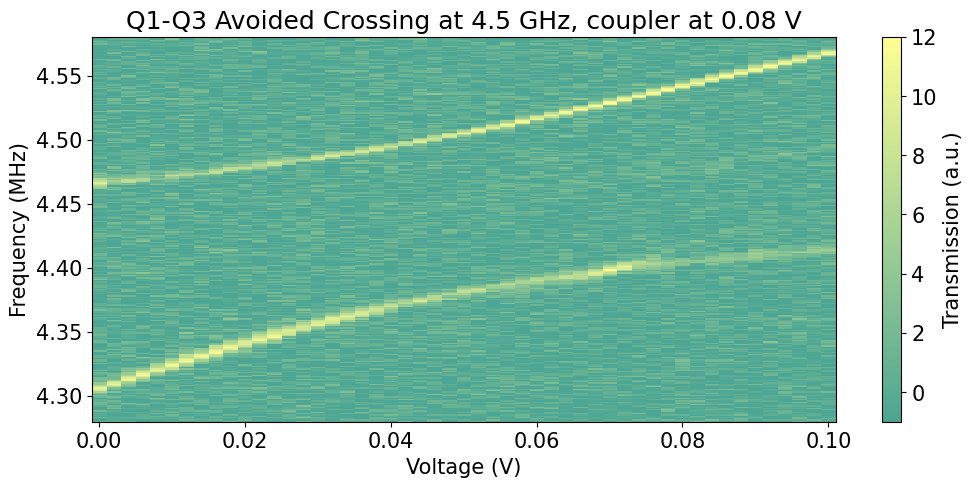

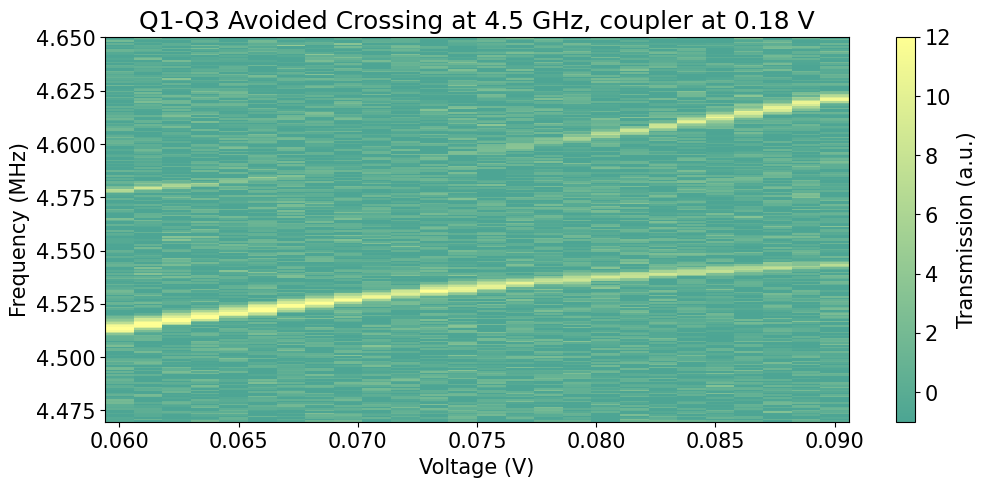

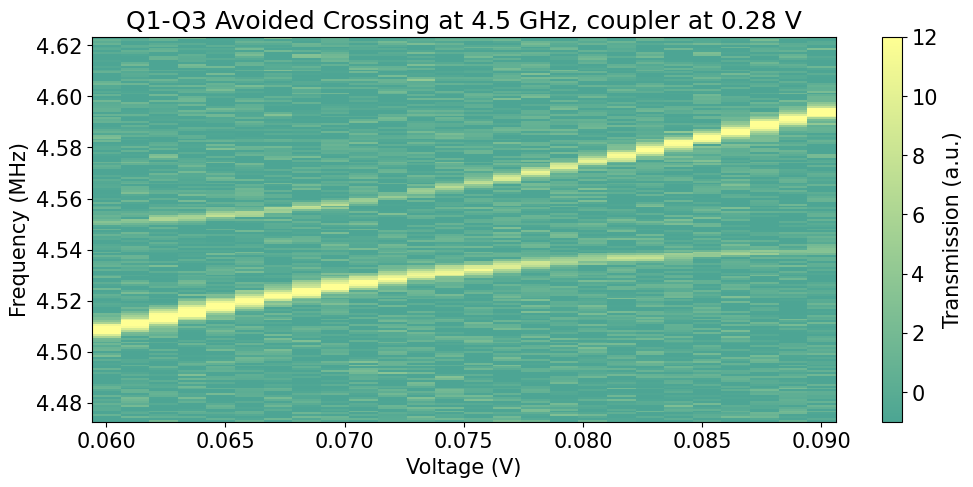

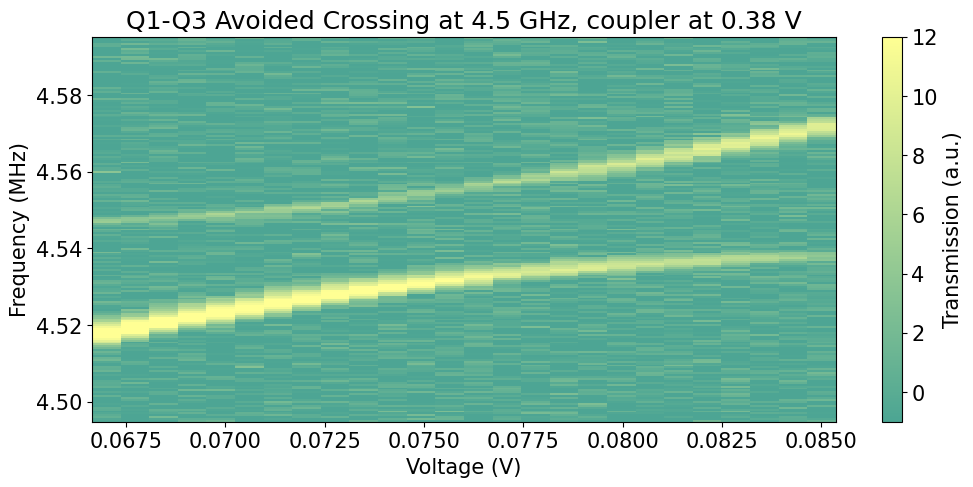

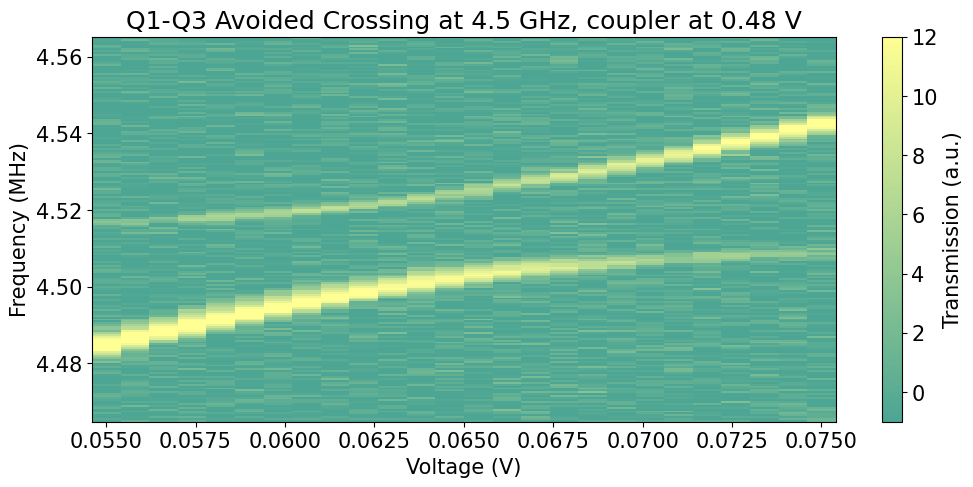

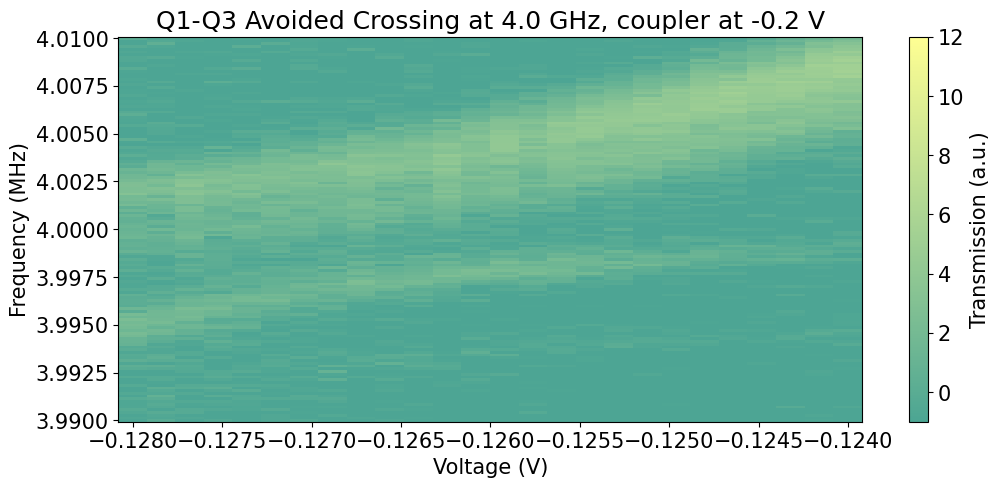

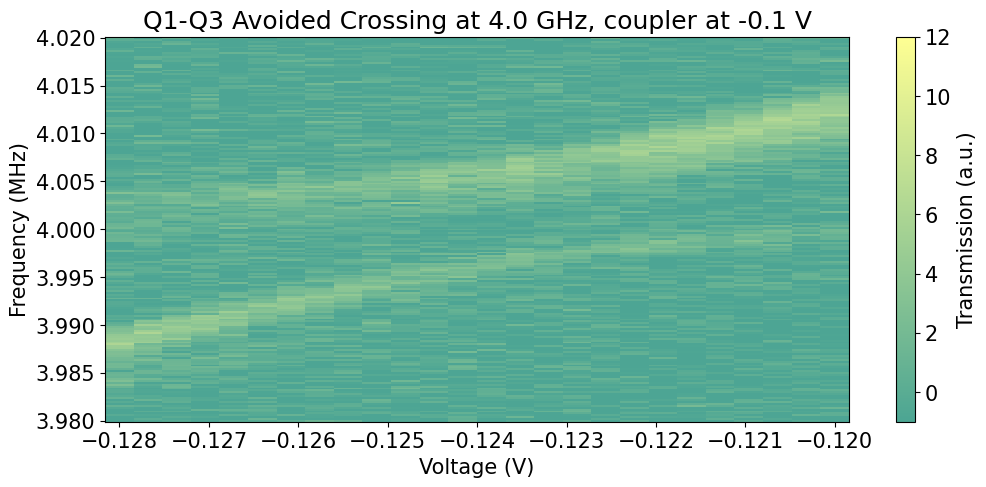

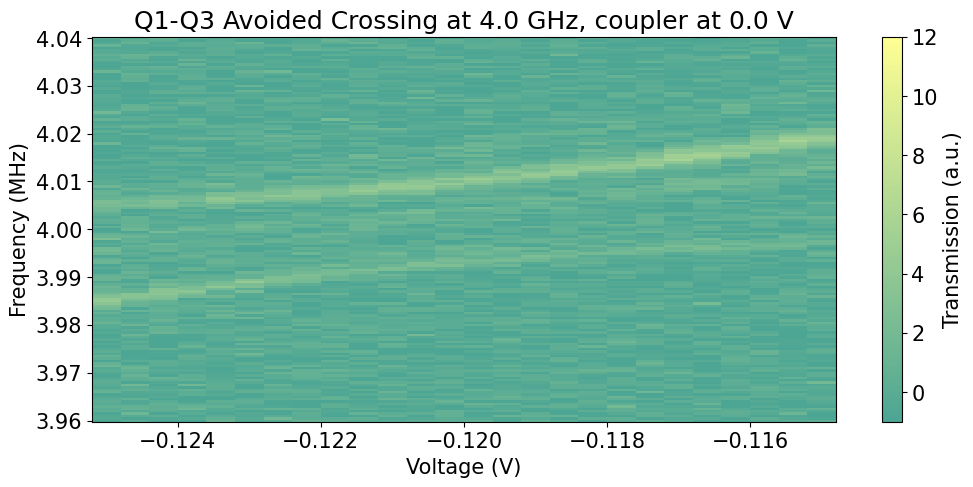

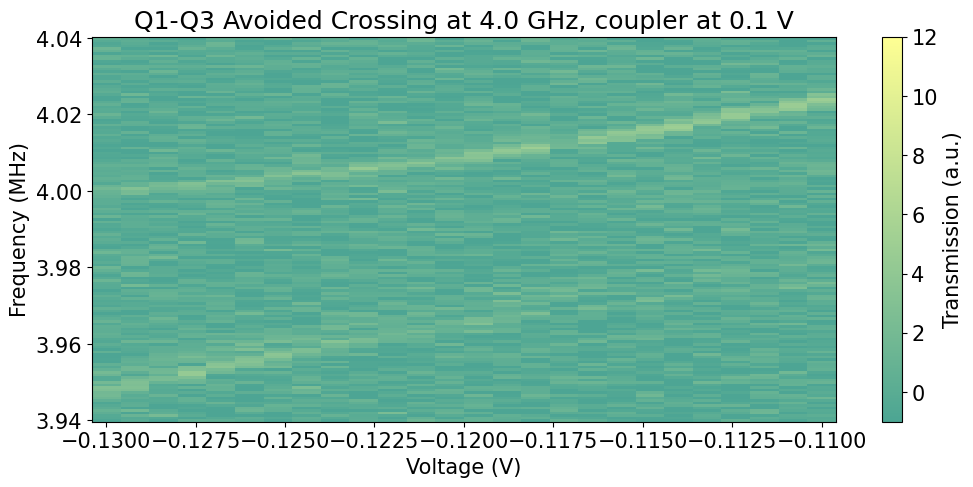

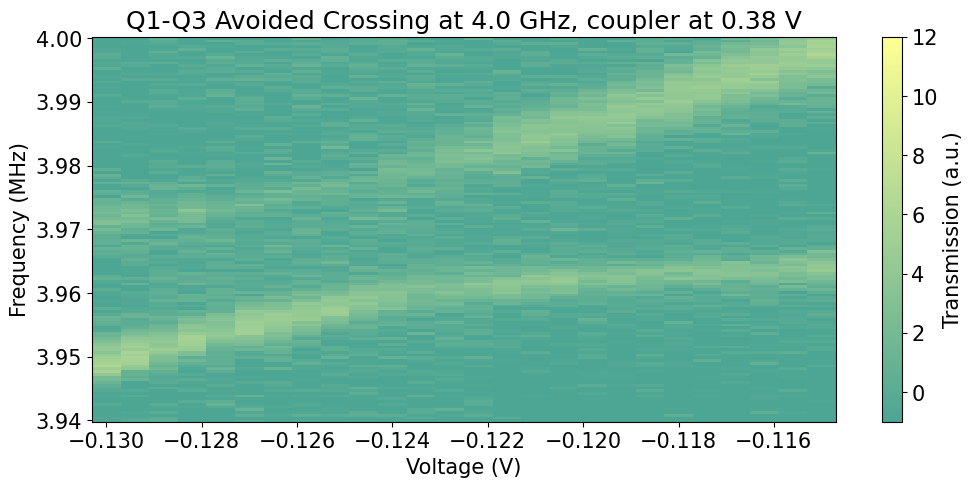

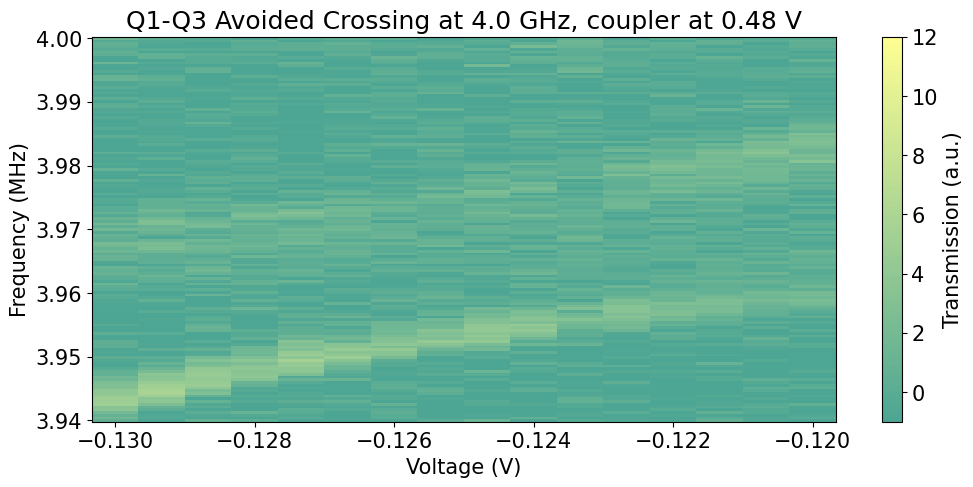

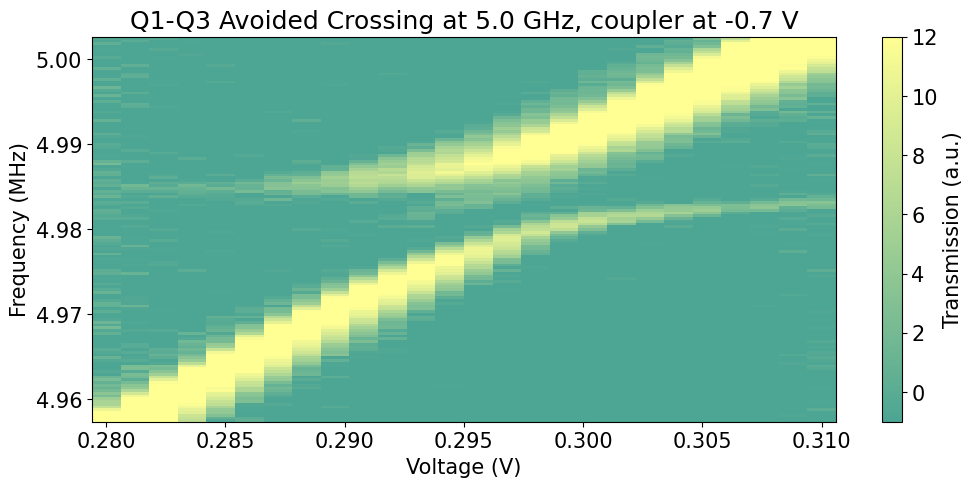

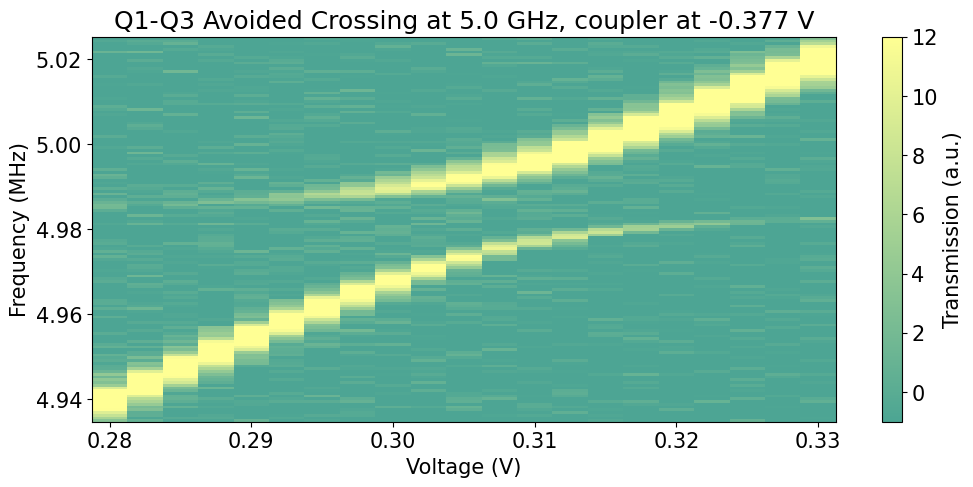

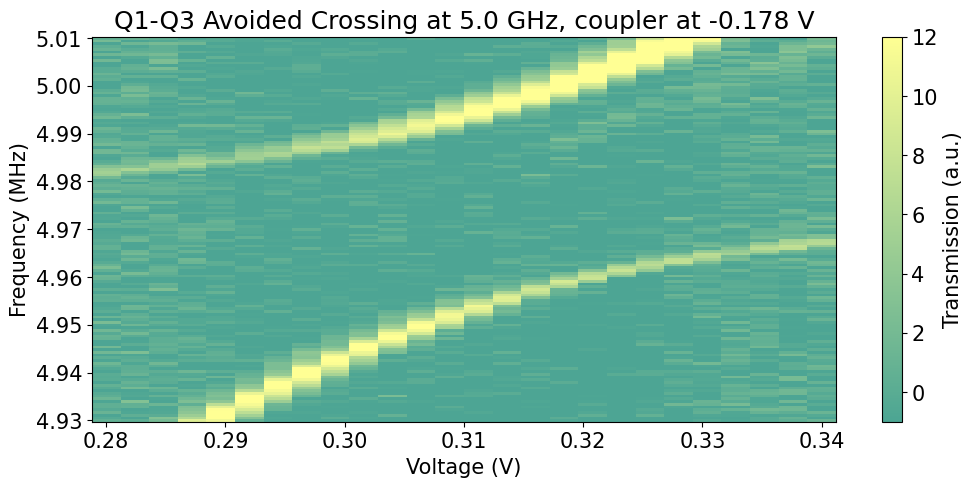

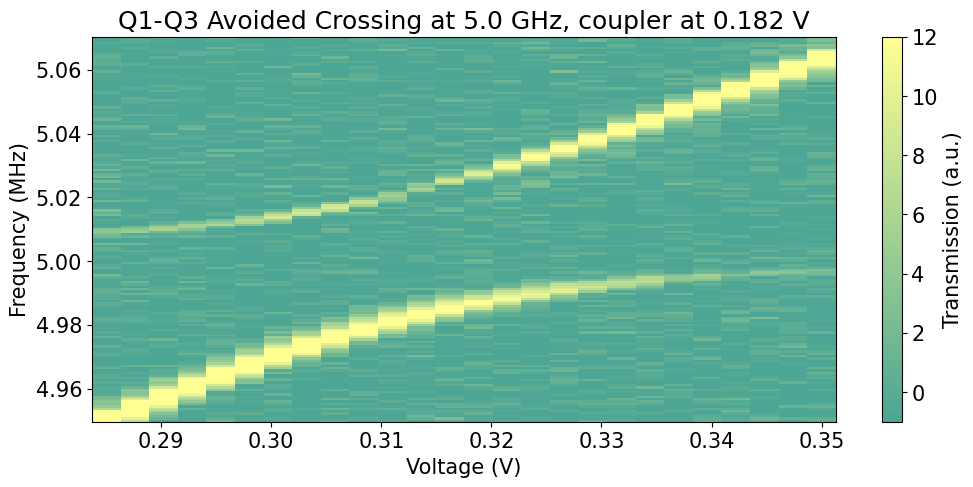

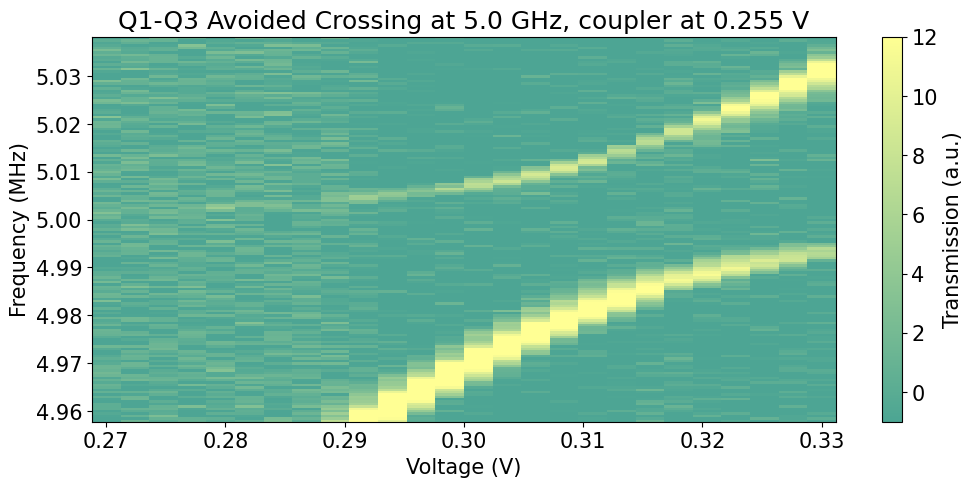

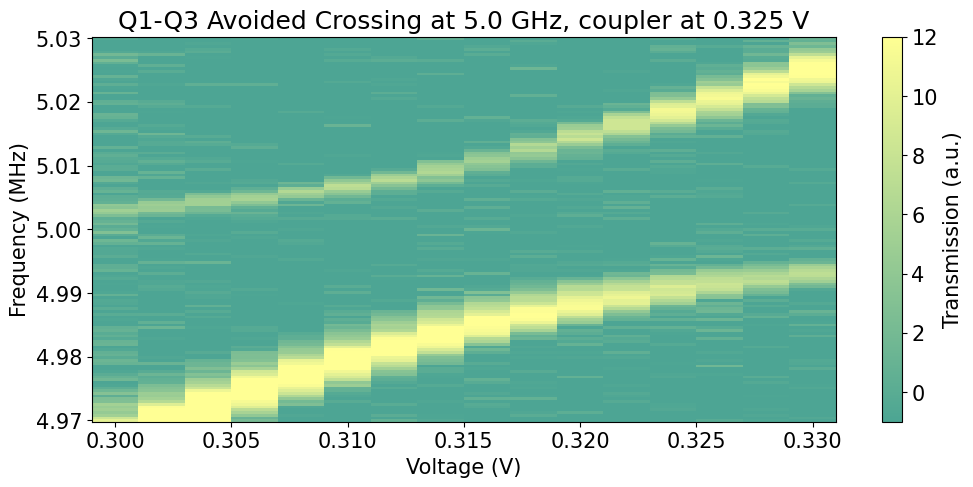

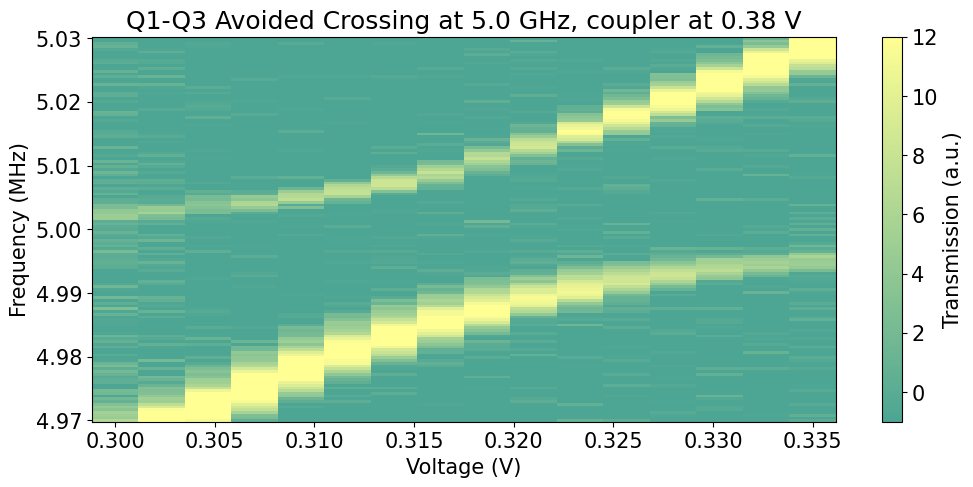

In [11]:
# plot transmission data

plot_transmission_data_qubits = all_qubits
plot_transmission_data_qubits = ['Q1', 'Q3']

plot_transmission_data_frequencies = all_qubit_frequencies

plot_transmission_data_qubits = itertools.product(plot_transmission_data_qubits, plot_transmission_data_qubits, plot_transmission_data_frequencies)

for qubit_1, qubit_2, qubit_frequency in plot_transmission_data_qubits:
    
    if (qubit_1, qubit_2, qubit_frequency) in qubit_pair_to_filenames:
        
        filename = qubit_pair_to_filenames[(qubit_1, qubit_2, qubit_frequency)]
        
        if isinstance(filename, str):
            filename_dict = {'-': filename}
        elif isinstance(filename, dict):
            filename_dict = filename
            
        for coupler_voltage, filename in filename_dict.items(): 

            voltages, frequencies, transmission_data = get_data(filename)


            frequency_step = frequencies[1] - frequencies[0]
            voltage_step = voltages[1] - voltages[0]

            if coupler_voltage == '-':
                title = f'{qubit_1}-{qubit_2} Avoided Crossing at {qubit_frequency} GHz'
            else:
                title = f'{qubit_1}-{qubit_2} Avoided Crossing at {qubit_frequency} GHz, coupler at {coupler_voltage} V'
            
            plot_spec_data(voltages, frequencies, transmission_data, title=title, vmax=12, vmin=-1)

        
# plot_spec_data(voltages, frequencies, transmission_data, title='Q1-Q2 Avoided Crossing', vmax=8, vmin=-1)
# plot_spec_data(voltages, frequencies, transmission_data, title='Q2-Q3 Avoided Crossing', vmax=5, vmin=-1)



# 2. Analyze Avoided Crossings

### 2.1 Fit Peaks

In [12]:
qubit_coupler_to_voltages = {}
qubit_coupler_to_frequencies = {}

for qubit_pair in itertools.product(all_qubits, all_qubits, all_qubit_frequencies):
    qubit_coupler_to_voltages[qubit_pair] = {}
    qubit_coupler_to_frequencies[qubit_pair] = {}    

In [62]:
qubit_pair_to_middle_frequency_index = {}

qubit_pair_to_middle_frequency_index[('Q1', 'Q2', 4.5)] = 40
qubit_pair_to_middle_frequency_index[('Q2', 'Q3', 4.5)] = 80

qubit_pair_to_middle_frequency_index[('Q1', 'Q3', 4.5)] = {'-0.5': 40,
                                                          '-0.4': 52,
                                                          '-0.3': 40,
                                                          '-0.2': 40,
                                                          '-0.1': 40,
                                                          '0.0': 100,
                                                          '0.08': 160,
                                                          '0.18': 120,
                                                          '0.28': 95,
                                                          '0.38': 90,
                                                          '0.48': 90}

qubit_pair_to_middle_frequency_index[('Q1', 'Q3', 4.0)] = {'-0.2': 80,
                                                          '-0.1': 90,
                                                          '0.0': 90,
                                                          '0.1': 75,
                                                          '0.38': 60,
                                                          '0.48': 50}

qubit_pair_to_middle_frequency_index[('Q1', 'Q3', 5.0)] = {'-0.7': 80,
                                                           '-0.377': 70,
                                                           '-0.178': 70,
                                                           '0.182': 70,
                                                           '0.255': 70,
                                                           '0.325': 70,
                                                           '0.38': 70}

qubit_pair_to_voltage_start_index = {}

qubit_pair_to_voltage_start_index[('Q1', 'Q3', 4.5)] = {'-0.5': 0,
                                                      '-0.4': 0,
                                                      '-0.3': 0,
                                                      '-0.2': 0,
                                                      '-0.1': 0,
                                                       '0.0': 0}





-0.4
middle frequency index: 52
number of frequency points: 101
given "middle frequency index" is at frequency: 4.5558000000000005


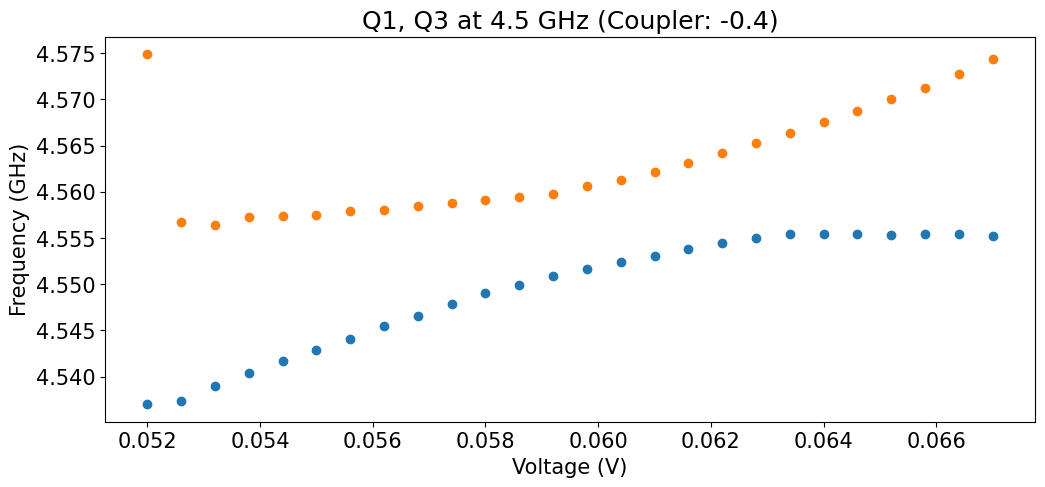

In [63]:
# Fit coupler peaks

extract_qubit_pairs = itertools.product(all_qubits, all_qubits, all_qubit_frequencies)
# extract_qubit_pairs = [('Q1', 'Q3')]
# extract_qubit_pairs = [('Q2', 'Q3'), ('Q1', 'Q3')]
# extract_qubit_pairs = [('Q1', 'Q2')]
extract_qubit_pairs = [('Q1', 'Q3', 5.0)]
extract_qubit_pairs = [('Q1', 'Q3', 4.5)]

extract_coupler_labels = None
extract_coupler_labels = ['-0.4']
# extract_coupler_labels = ['0.38']


for qubit_1, qubit_2, qubit_frequency in extract_qubit_pairs:
    
    if not (qubit_1, qubit_2, qubit_frequency) in qubit_pair_to_filenames:
        continue

    plot_fits = False
    start_index = 5
    frequency_index_span = 25
    
    
    
    
    
        
    qubit_pair_filenames = qubit_pair_to_filenames[(qubit_1, qubit_2, qubit_frequency)]
    if isinstance(qubit_pair_filenames, str):
        qubit_pair_filenames = {'-': qubit_pair_filenames}
        
    for coupler_label, file in qubit_pair_filenames.items():
         if extract_coupler_labels is None or len(extract_coupler_labels) == 0 or coupler_label in extract_coupler_labels:
                
            voltage_start_index = 0
            if (qubit_1, qubit_2, qubit_frequency) in qubit_pair_to_voltage_start_index:
                if coupler_label in qubit_pair_to_voltage_start_index[(qubit_1, qubit_2, qubit_frequency)]:
                    voltage_start_index = qubit_pair_to_voltage_start_index[(qubit_1, qubit_2, qubit_frequency)][coupler_label]
                
            print(coupler_label)
            
            qubit_middle_frequency = qubit_pair_to_middle_frequency_index[(qubit_1, qubit_2, qubit_frequency)]
            
            if isinstance(qubit_middle_frequency, int):
                middle_frequency_index = qubit_middle_frequency
            if isinstance(qubit_middle_frequency, dict):
                middle_frequency_index = qubit_middle_frequency[coupler_label]
            
       

            voltage_data, frequency_data, transmission_data = get_data(file)
        
            
            print(f'middle frequency index: {middle_frequency_index}')
            print(f'number of frequency points: {len(frequency_data)}')
            print(f'given "middle frequency index" is at frequency: {frequency_data[middle_frequency_index]}')
            
            file_voltages, file_frequencies, error = get_avoided_crossing_frequencies(voltage_data, frequency_data, transmission_data, voltage_start_index=voltage_start_index,
                                                                                      middle_frequency_index=middle_frequency_index, start_index=start_index,
                                                                                      frequency_index_span=frequency_index_span, plot_fits=plot_fits)
            plt.show()


            qubit_coupler_to_voltages[(qubit_1, qubit_2, qubit_frequency)][coupler_label] = np.array(file_voltages)
            qubit_coupler_to_frequencies[(qubit_1, qubit_2, qubit_frequency)][coupler_label] = np.array(file_frequencies)

            for i in range(len(file_voltages)):
                plt.plot(np.array(file_voltages[i]), np.array(file_frequencies[i]), marker='o', linestyle='')

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            if coupler_label == '-':
                title = f'{qubit_1}, {qubit_2} at {qubit_frequency} GHz'
            else:
                title = f'{qubit_1}, {qubit_2} at {qubit_frequency} GHz (Coupler: {coupler_label})'

            plt.title(title)

            plt.show()



### 2.2 Fit Avoided Crossing

In [64]:
def avoided_crossing_function(voltage, V0, g, A):
    return np.sqrt(4*np.power(g, 2) + A*np.power(voltage - V0, 2))

In [65]:
qubit_pair_to_coupling = {qubit_pair: {} for qubit_pair in itertools.product(all_qubits, all_qubits, all_qubit_frequencies)}

In [66]:
qubit_pair_to_ignore_indices = {}

qubit_pair_to_ignore_indices[('Q1', 'Q2', 4.5)] = {'-': [59]}

qubit_pair_to_ignore_indices[('Q2', 'Q3', 4.5)] = {'-': []}

qubit_pair_to_ignore_indices[('Q1', 'Q3', 4.5)] = {'-0.5': [5, 6],
                                                  '-0.4': [0, 23],
                                                  '-0.3': [22, 24, 25],
                                                  '-0.2': [16, 17, 18, 19, 21, 24],
                                                  '-0.1': [0, 1, 2, 3, 4, 5, 20, 22, 23, 24, 25, 26, 29, 30],
                                                  '0.0': [],
                                                  '0.08': [],
                                                  '0.18': [6, 7, 8, 9, 10, 11, 12, 13]}

qubit_pair_to_ignore_indices[('Q1', 'Q3', 4.0)] = {'-0.2': [2, 4, 5, 6, 9],
                                                   '-0.1': [20],
                                                   '0.0': [13, 25],
                                                   '0.1': [23],
                                                   '0.38': [9],
                                                   '0.48': []}


qubit_pair_to_ignore_indices[('Q1', 'Q3', 5.0)] = {'-0.7': [0, 1, 23],
                                                   '-0.377': [1, 16, 17, 18, 19, 20],
                                                   '-0.178': [0, 1, 2, 3, 4, 5, 21, 22, 23, 24, 25],
                                                   '0.182': [],
                                                   '0.255': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                                   '0.325': [0, 1],
                                                   '0.38': [0, 1]}

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 25]
0.0604
coupling_strength: 4.354128018227049 MHz


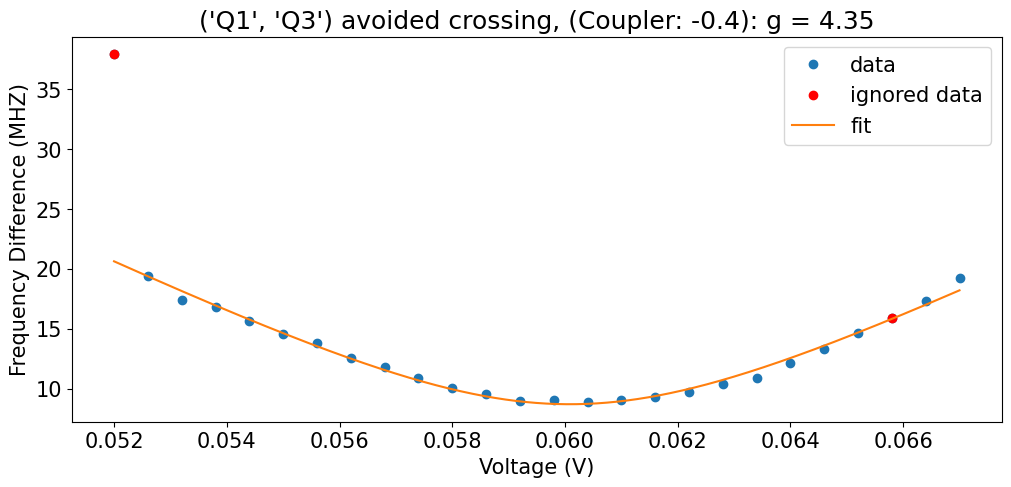

In [67]:
# Fit coupler peaks

avoided_crossing_qubit_pairs = itertools.product(all_qubits, all_qubits, all_qubit_frequencies)
# avoided_crossing_qubit_pairs = [('Q1', 'Q3')]
# avoided_crossing_qubit_pairs = [('Q2', 'Q3')]
# avoided_crossing_qubit_pairs = [('Q1', 'Q2')]

avoided_crossing_qubit_pairs = [('Q1', 'Q2', 4.5), ('Q2', 'Q3', 4.5), ('Q1', 'Q3', 4.5)]
avoided_crossing_qubit_pairs = [('Q1', 'Q3', 4.5)]
# avoided_crossing_qubit_pairs = [('Q1', 'Q3', 5.0)]

avoided_crossing_coupler_labels = ['-0.4']
# avoided_crossing_coupler_labels = []



for qubit_1, qubit_2, qubit_frequency in avoided_crossing_qubit_pairs:
    
    if not (qubit_1, qubit_2, qubit_frequency) in qubit_coupler_to_voltages:
        continue
        
    qubit_pair_voltages = qubit_coupler_to_voltages[(qubit_1, qubit_2, qubit_frequency)]
    qubit_pair_frequencies = qubit_coupler_to_frequencies[(qubit_1, qubit_2, qubit_frequency)]

    for coupler_label in qubit_pair_voltages:

        if avoided_crossing_coupler_labels is None or len(avoided_crossing_coupler_labels) == 0 or coupler_label in avoided_crossing_coupler_labels:

            avoided_crossing_voltages = qubit_pair_voltages[coupler_label][0]
            avoided_crossing_frequencies = qubit_pair_frequencies[coupler_label] 
            avoided_crossing_difference = (avoided_crossing_frequencies[1] - avoided_crossing_frequencies[0])*1e3


            if not (qubit_1, qubit_2, qubit_frequency) in qubit_pair_to_ignore_indices:
                ignore_indices = []
            elif not coupler_label in qubit_pair_to_ignore_indices[qubit_1, qubit_2, qubit_frequency]:
                ignore_indices = []
            else:
                ignore_indices = qubit_pair_to_ignore_indices[qubit_1, qubit_2, qubit_frequency][coupler_label]

            include_indices = set(range(len(avoided_crossing_voltages))) - set(ignore_indices)
            include_indices = np.array(list(include_indices))
            print(include_indices)

            plt.plot(avoided_crossing_voltages, avoided_crossing_difference, linestyle='', marker='o', label='data')
            plt.plot(avoided_crossing_voltages[ignore_indices], avoided_crossing_difference[ignore_indices], linestyle='', marker='o', color='red', label='ignored data')


            included_voltages = avoided_crossing_voltages[include_indices]
            included_difference = avoided_crossing_difference[include_indices]

            minimum_index = np.argmin(included_difference)
            voltage_at_minimum = included_voltages[minimum_index]
            difference_at_minimum = included_difference[minimum_index]

            initial_guess = (voltage_at_minimum, difference_at_minimum/2, 1e6)
            print(voltage_at_minimum)

            fit_voltages = np.linspace(avoided_crossing_voltages[0], avoided_crossing_voltages[-1], 1001)

#             plt.plot(fit_voltages, avoided_crossing_function(fit_voltages, *initial_guess), label='guess')

            popt, pcov = curve_fit(avoided_crossing_function, included_voltages, included_difference, p0=initial_guess)
            plt.plot(fit_voltages, avoided_crossing_function(fit_voltages, *popt), label='fit')

            coupling_strength = popt[1]
            print(f'coupling_strength: {coupling_strength} MHz')

            qubit_pair_to_coupling[qubit_1, qubit_2, qubit_frequency][coupler_label] = coupling_strength

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency Difference (MHZ)')

            if coupler_label == '-':
                title = f'{qubit_1, qubit_2} avoided crossing: g = {np.round(coupling_strength, 2)}'
            else:
                title = f'{qubit_1, qubit_2} avoided crossing, (Coupler: {coupler_label}): g = {np.round(coupling_strength, 2)}'

            plt.title(title)
            plt.legend()
            
            plt.show()

### 2.3 Plot vs Coupler Frequency

In [249]:
def frequency_model_fit(x, x0, a, b, c, d):
    return np.sqrt(a*np.sqrt(np.power(np.cos(b*(x-x0)),2) + (d**2)*np.power(np.sin(b*(x-x0)),2))) - c

In [253]:
coupler_to_tunable_transmon_model_parameters = {}

In [254]:
### import coupler spectra

for coupler in all_couplers:
    try:
        filename = f'..\\coupler_spectroscopy\\tunable_transmon_model_parameters\\{coupler}.csv'
            
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
            
            i = 0
            for row in reader:
                if i == 1:
                    coupler_to_tunable_transmon_model_parameters[coupler] = [float(row[j]) for j in range(len(row))]
                i += 1
    except FileNotFoundError as e:
        print(f'File not found: {e}')
    

In [256]:
coupler_to_flux_to_voltage = {}
coupler_to_voltage_to_flux = {}
coupler_to_function = {}
coupler_to_inverse_function = {}

[-1.0004569133170012, 60.52029801388207, 1.0818701910680237, 0.174, 0.0]
[0.942309230482974, 60.59927748501909, 1.0483120480790746, 0.174, 0.0]
[-1.091664355667214, 60.42068832311683, 1.1086058696696275, 0.174, 0.0]


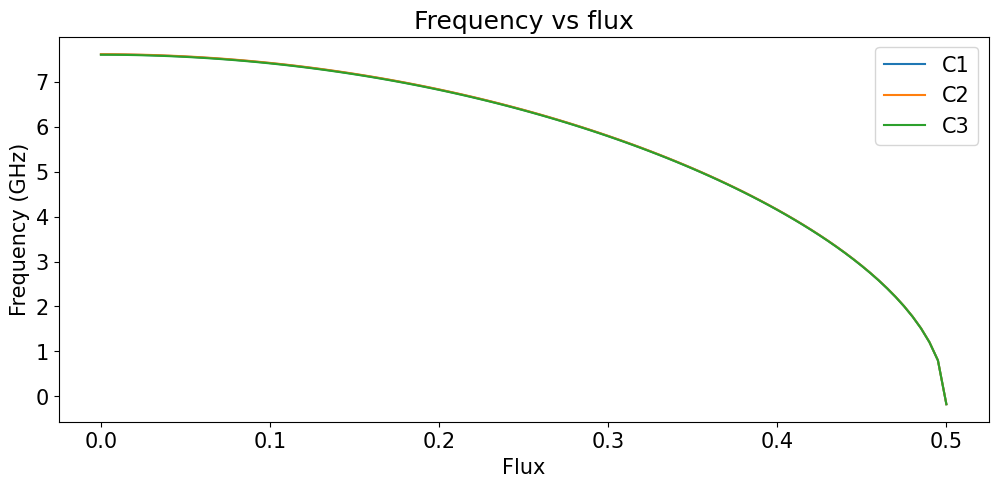

In [258]:
### create voltage to/from frequency functions

### create frequency to flux function and inverse

coupler_to_function = {}
coupler_to_inverse_function = {}

coupler_to_flux_to_voltage = {}
coupler_to_voltage_to_flux = {}

for coupler in coupler_to_tunable_transmon_model_parameters:
    
    transmon_popt = coupler_to_tunable_transmon_model_parameters[coupler]
    
    x0, a, b, c, d = transmon_popt
    
    print(transmon_popt)
    
    
    def create_coupler_flux_to_voltage(_popt):
        x0, a, b, c, d = _popt
        return lambda x: (np.pi*x)/b + x0
    
    def create_coupler_voltage_to_flux(_popt):
        x0, a, b, c, d = _popt
        return lambda x: b*(x - x0)/np.pi
    
    coupler_to_flux_to_voltage[coupler] = create_coupler_flux_to_voltage(transmon_popt)
    coupler_to_voltage_to_flux[coupler] = create_coupler_voltage_to_flux(transmon_popt)
    
    # takes a flux value and outputs frequency
    def create_coupler_function(_popt):
        x0, a, b, c, d = _popt
        return lambda x: frequency_model_fit((np.pi*x)/b + x0, *_popt)
    
    coupler_function = create_coupler_function(transmon_popt)
    coupler_to_function[coupler] = coupler_function
    
    # takes a frequency value and outputs flux
    def create_coupler_inverse_function(coupler_function):
        def find_root(f, __coupler_function):
            bracket = (0, 0.5)

            if isinstance(f, (list, np.ndarray)):
                fluxes = np.empty(len(f))
                for i in range(len(f)):
                    root_function = lambda flux: __coupler_function(flux) - f[i]
                    result = root_scalar(root_function, bracket=bracket)
                    fluxes[i] = result.root
                return fluxes
            elif isinstance(f, (int, float)):
                root_function = lambda flux: __coupler_function(flux) - f
                result = root_scalar(root_function, bracket=bracket)
                return result.root
        return lambda f: find_root(f, coupler_function)
        
    
    coupler_to_inverse_function[coupler] = create_coupler_inverse_function(coupler_function)
    
    
    fluxes = np.linspace(0, 0.5, 101)
    frequencies = coupler_function(fluxes)
    
    plt.plot(fluxes, frequencies, label=coupler)
    

plt.xlabel('Flux')
plt.ylabel('Frequency (GHz)')

plt.legend()
plt.title(f'Frequency vs flux')
plt.show()

In [337]:
print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(-0.2))))
print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(-0.1))))
print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(0.0))))
print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(0.1))))

print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(0.25))))
print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(0.3))))

print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(0.38))))
print(coupler_to_function['C1'](coupler_to_voltage_to_flux['C1'](float(0.48))))


6.087808919148513
5.657230401977329
5.155037851521427
4.565406602559366
3.443604302139249
2.968161644981904
1.9881371805147254
1.1926438715526038


C1 4.5
[10.951502004963853, 11.4787693736607, 16.495290434113347, 30.79573252565476, -62.27441485679065, -26.904175265194755, -13.298229003469181, -8.28186203873079, -6.022676612417601, -4.659742010780116, -3.4593880147371157]
[1.1926438715526038, 1.9881371805147254, 3.16706672851525, 4.0117007297759475, 4.691448751614851, 5.155037851521427, 5.657230401977329, 6.087808919148513, 6.456140847179906, 6.768137541375335, 7.027684160595141]

C1 4.0
[9.486701428735486, 9.463302340327441, -20.357360519760338, -8.228397378802145, -4.624708742648204, -3.0116428226130028]
[1.1926438715526038, 1.9881371805147254, 4.565406602559366, 5.155037851521427, 5.657230401977329, 6.087808919148513]

C1 5.0
[11.529093971348328, 12.59409096278043, 14.89793707474878, 19.56008494842589, -20.57290832977891, -9.002185773049387, -5.073646000794902]
[1.9881371805147254, 2.699119718296873, 3.3991276568264284, 3.996696185222904, 5.998681954655695, 6.701139395900567, 7.399046554878801]



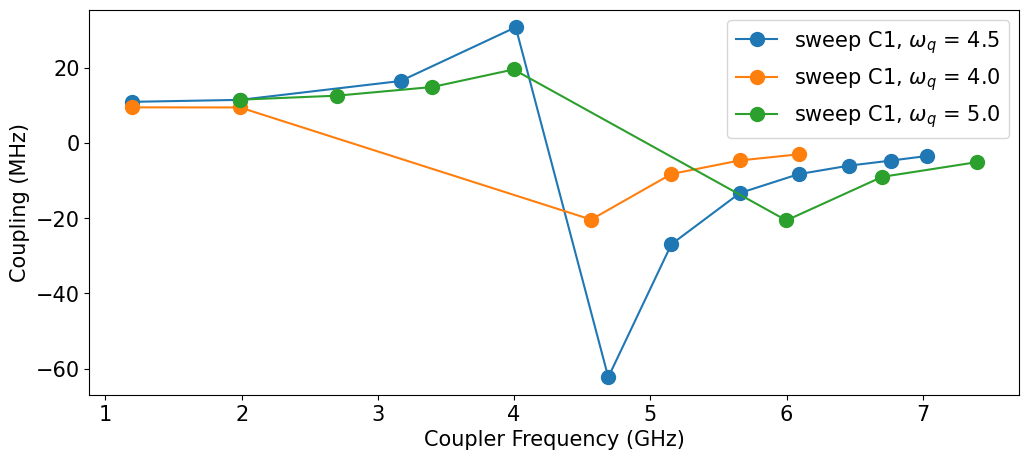

In [329]:

for qubit_1, qubit_2, qubit_frequency in itertools.product(all_qubits, all_qubits, all_qubit_frequencies):
    if (qubit_1, qubit_2, qubit_frequency) in qubit_pair_to_coupling:
        
        if (qubit_1, qubit_2) == ('Q1', 'Q3'):
            coupler = 'C1'
        elif (qubit_1, qubit_2) == ('Q2', 'Q4'):
            coupler = 'C2'
        elif (qubit_1, qubit_2) == ('Q3', 'Q5'):
            coupler = 'C3'
        else:
            continue
            
        coupling_strengths = []
        coupler_frequencies = []
    
        
        for coupler_voltage in qubit_pair_to_coupling[(qubit_1, qubit_2, qubit_frequency)]:
            coupler_frequency = coupler_to_function[coupler](coupler_to_voltage_to_flux[coupler](float(coupler_voltage)))
            
            coupler_frequencies.append(coupler_frequency)
            
            if coupler_frequency > qubit_frequency:
                multiplier = -1
            else:
                multiplier = 1
            
            coupling_strengths.append(qubit_pair_to_coupling[qubit_1, qubit_2, qubit_frequency][coupler_voltage]*multiplier)
            
        sorted_indices = np.argsort(coupler_frequencies)
        
       
        if len(coupler_frequencies) > 0:
            
            print(coupler, qubit_frequency)

            coupler_frequencies = np.array(coupler_frequencies)[sorted_indices]
            coupling_strengths = np.array(coupling_strengths)[sorted_indices]

            plt.plot(coupler_frequencies, coupling_strengths, marker='o', ms=10, label=f'sweep {coupler}, $\omega_q$ = {qubit_frequency}')

            print('[', end='')
            for i in range(len(coupling_strengths) - 1):
                print(coupling_strengths[i], end=', ')

            print(f'{coupling_strengths[-1]}]')
            
            print('[', end='')
            for i in range(len(coupler_frequencies) - 1):
                print(coupler_frequencies[i], end=', ')

            print(f'{coupler_frequencies[-1]}]')
            
            print()
            
            
plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Coupling (MHz)')

plt.legend()
plt.show()


In [340]:
coupler_voltages = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.08, 0.18, 0.28, 0.38, 0.48] # 4.5

coupling_strengths = []


            
print(qubit_pair_to_coupling['Q1', 'Q3', 4.5].keys())

for i in range(len(coupler_voltages)):

    coupler_voltage = coupler_voltages[i]
    
    if coupler_voltage < 0.1:
        multiplier = -1
    else:
        multiplier = 1
    
    coupling_strengths.append(qubit_pair_to_coupling['Q1', 'Q3', 4.5][str(coupler_voltage)]*multiplier)



print('[', end='')
for i in range(len(coupling_strengths) - 1):
    print(coupling_strengths[i], end=', ')
    
print(f'{coupling_strengths[-1]}]')

dict_keys(['-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.08', '0.18', '0.28', '0.38', '0.48'])


KeyError: '0.244'

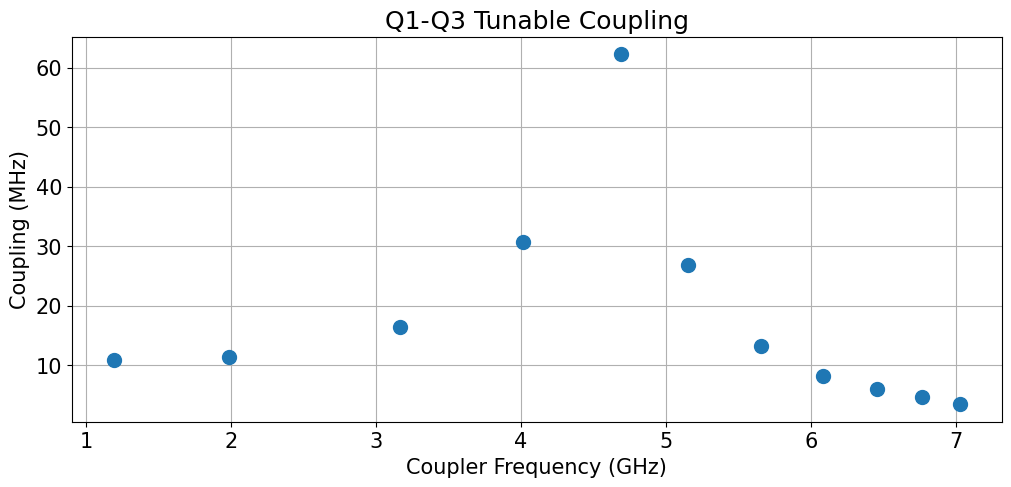

In [162]:
frequencies = [7.0276841605951414, 6.768137541375336, 6.456140847179906, 6.087808919148513, 5.65723040197733, 5.155037851521428, 4.691448751614851, 4.0117007297759475, 3.16706672851525, 1.9881371805147254, 1.1926438715526035]
coupling_strengths = list(qubit_pair_to_coupling['Q1', 'Q3', 4.5].values())


plt.plot(frequencies, coupling_strengths, marker='o', ms=10, linestyle='')

plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Coupling (MHz)')

plt.title('Q1-Q3 Tunable Coupling')

plt.grid()

plt.show()

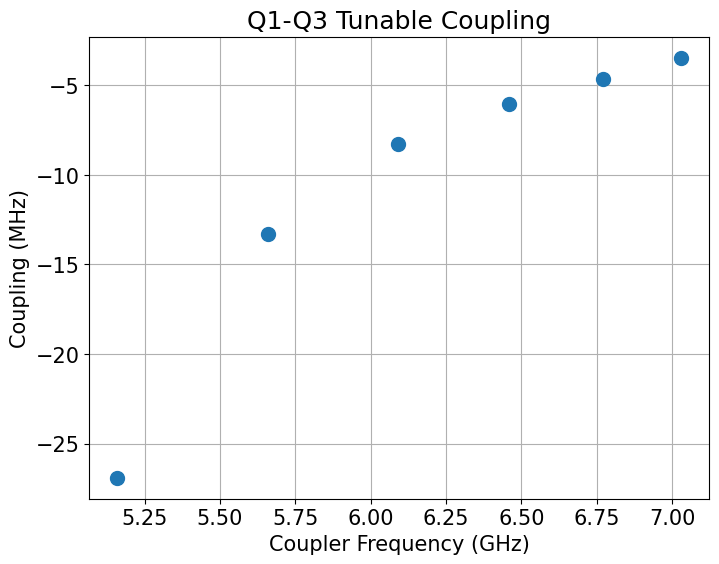

In [150]:
frequencies = [7.03, 6.77, 6.46, 6.09, 5.66, 5.16]
coupling_strengths = -np.array([3.46, 4.66, 6.02, 8.28, 13.3, 26.9])

plt.figure(figsize=(8, 6))

plt.plot(frequencies, coupling_strengths, marker='o', ms=10, linestyle='')

plt.xlabel('Coupler Frequency (GHz)')
plt.ylabel('Coupling (MHz)')

plt.title('Q1-Q3 Tunable Coupling')

plt.grid()

plt.show()